# Importing Neural Networks into OMLT

This notebook shows how to import your neural networks into OMLT.

OMLT includes an importer for neural networks saved as [ONNX](https://onnx.ai/). This notebook shows you how to save neural networks into ONNX from a number of popular machine learning libraries. Finally, we show how to import the ONNX file into OMLT.

Throughout this notebook we are going to use Pima Indians Diabetes dataset to train a neural network that predicts whether or not a patient has diabetes, based on a set of medical data. This dataset is from the National Institute of Diabetes and Digestive and Kidney Diseases [0], licensed under the CC0 (Public Domain) license.
You can find more information about this dataset on [Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

We start by importing the data into a Pandas dataframe.

In [1]:
import pandas as pd

df = pd.read_csv('../data/diabetes.csv')

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


We then visualize the distribution of column values.

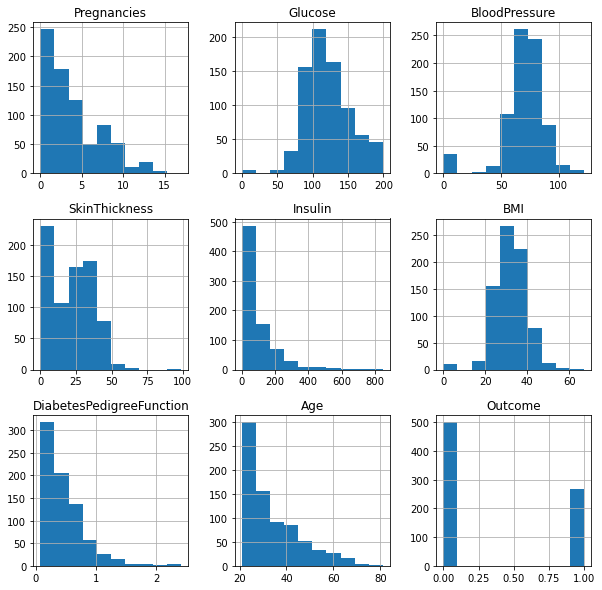

In [2]:
_ = df.hist(figsize=(10, 10))

Finally we split the data into input and output variables

In [3]:
X = df.iloc[:, :8].values
Y = df.iloc[:, 8].values

## Storing variables bounds

When developing optimization models is important to define bounds on variables. If the neural network includes ReLU activation functions, then OMLT requires all input variables to be bounded to produce a tighter MIP formulation of the ReLU activations.

OMLT includes a function to write the input bounds in a format that can be read back later together with the ONNX model.

We start by computing bounds on the eight input variables of our simple neural networks. We will use `input_bounds` later when we save the ONNX model.

In [4]:
import numpy as np

lb = np.min(X, axis=0)
ub = np.max(X, axis=0)
input_bounds = [(l, u) for l, u in zip(lb, ub)]
input_bounds

[(0.0, 17.0),
 (0.0, 199.0),
 (0.0, 122.0),
 (0.0, 99.0),
 (0.0, 846.0),
 (0.0, 67.1),
 (0.078, 2.42),
 (21.0, 81.0)]

We import the function used to write the ONNX model together with its bounds.

In [5]:
from omlt.io import write_onnx_model_with_bounds, load_onnx_neural_network_with_bounds

You can visualize the neural network ONNX model using an app like [Netron](https://netron.app/).

These functions are only used in the notebooks and are not related to ONNX or OMLT.

In [6]:
import tempfile

from IPython.display import Image

## Keras


We start by building a simple Keras model with 3 dense layers. 

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We then fit the model to the dataset

In [8]:
model.fit(X, Y, epochs=150, batch_size=10)

Epoch 1/150
77/77 [==============================] - 0s 1ms/step - loss: 6.3354 - accuracy: 0.5677
Epoch 2/150
77/77 [==============================] - 0s 1ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 3/150
77/77 [==============================] - 0s 1ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 4/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 5/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 6/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 7/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 8/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 9/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 10/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 11/

77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 83/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 84/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 85/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 86/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 87/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 88/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 89/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 90/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 91/150
77/77 [==============================] - 0s 2ms/step - loss: 5.3827 - accuracy: 0.6510
Epoch 92/150


We can now export the Keras model to ONNX.

In [10]:
import tf2onnx

onnx_model, _ = tf2onnx.convert.from_keras(model)

with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    write_onnx_model_with_bounds(f.name, onnx_model, input_bounds)
    print(f"Wrote ONNX model with bounds at {f.name}")

Wrote ONNX model with bounds at /tmp/tmp2u0qvwd0.onnx


The model after serialization looks like the following:

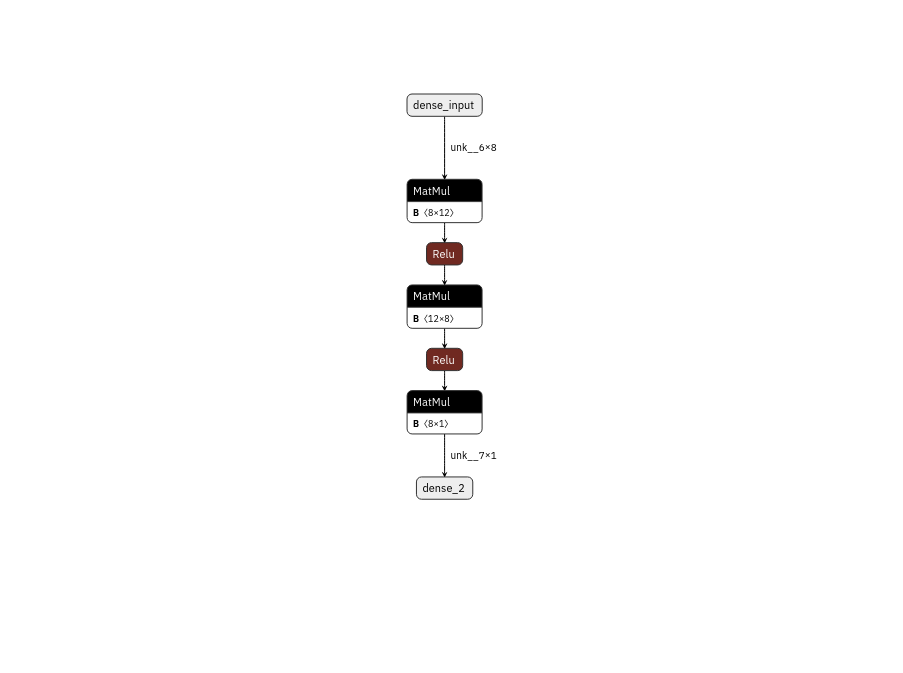

In [11]:
Image(filename='../images/simple-neural-network.png', height=600)

## PyTorch

We start by building a simple model using the PyTorch API.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

class PyTorchModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense_0 = nn.Linear(8, 12)
        self.dense_1 = nn.Linear(12, 1)
        self.out = nn.Linear(1, 1)

    def forward(self, x):
        x = F.relu(self.dense_0(x))
        x = F.relu(self.dense_1(x))
        x = self.out(x)
        return x

model = PyTorchModel()
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

dataset = TensorDataset(torch.as_tensor(X, dtype=torch.float32), torch.as_tensor(Y, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=10)

for epoch in range(150):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        y_batch_pred = model(x_batch)
        loss = loss_function(y_batch_pred, y_batch.view(*y_batch_pred.shape))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch number: {epoch} loss : {loss.item()}")


Epoch number: 0 loss : 0.25130271911621094
Epoch number: 10 loss : 0.25201597809791565
Epoch number: 20 loss : 0.2500983774662018
Epoch number: 30 loss : 0.2500978708267212
Epoch number: 40 loss : 0.25245341658592224
Epoch number: 50 loss : 0.2509850561618805
Epoch number: 60 loss : 0.25141310691833496
Epoch number: 70 loss : 0.2518356740474701
Epoch number: 80 loss : 0.250247597694397
Epoch number: 90 loss : 0.25029245018959045
Epoch number: 100 loss : 0.2565183639526367
Epoch number: 110 loss : 0.25006231665611267
Epoch number: 120 loss : 0.2502576410770416
Epoch number: 130 loss : 0.2532578110694885
Epoch number: 140 loss : 0.2514439821243286


We can now export the PyTorch model to ONNX. Notice that we need to specify that the first axis of the input should be ignored since it represent training batches. Also notice that PyTorch write the ONNX model directly to the specified file, so we don't pass the raw ONNX model to `write_onnx_model_with_bounds` and instead we only specify the bounds.

In [13]:
import torch.onnx

# model input used for exporting
x = torch.randn(10, 8, requires_grad=True)
pytorch_model = None
with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    torch.onnx.export(
        model,
        x,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    write_onnx_model_with_bounds(f.name, None, input_bounds)
    print(f"Wrote PyTorch model to {f.name}")
    pytorch_model = f.name

Wrote PyTorch model to /tmp/tmpw13siqwz.onnx


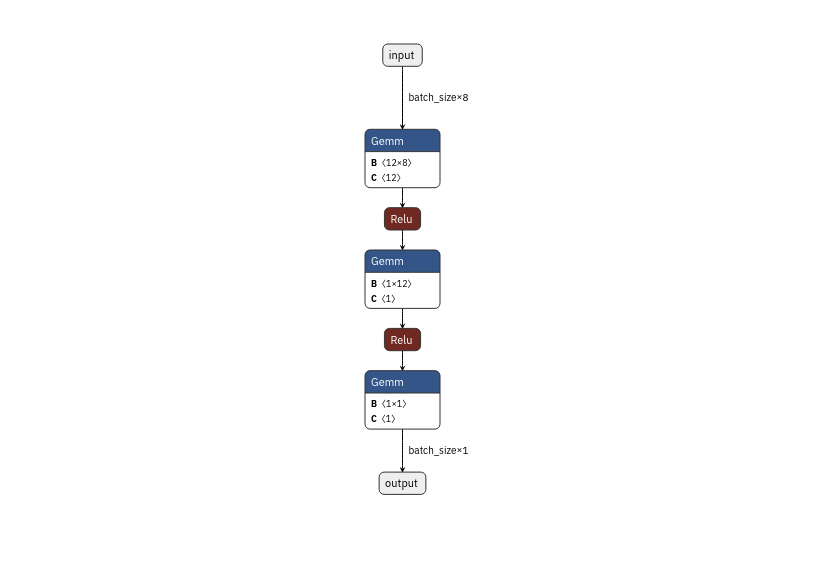

In [14]:
Image(filename='../images/torch-neural-network.png', height=500)

## Importing ONNX into OMLT

Finally, we can import the ONNX model and bounds into OMLT.

In [15]:
network_definition = load_onnx_neural_network_with_bounds(pytorch_model)

The network definition includes the bounds we defined at the beginning of this notebook.

In [16]:
network_definition.scaled_input_bounds

{0: (0.0, 17.0),
 1: (0.0, 199.0),
 2: (0.0, 122.0),
 3: (0.0, 99.0),
 4: (0.0, 846.0),
 5: (0.0, 67.1),
 6: (0.078, 2.42),
 7: (21.0, 81.0)}

We can iterate over the layers to print their input and output shape, together with the activation function.

In [17]:
for layer_id, layer in enumerate(network_definition.layers):
    print(f"{layer_id}\t{layer}\t{layer.activation}")

0	InputLayer(input_size=[8], output_size=[8])	linear
1	DenseLayer(input_size=[8], output_size=[12])	relu
2	DenseLayer(input_size=[12], output_size=[1])	relu
3	DenseLayer(input_size=[1], output_size=[1])	linear


## References

[0] Smith, Jack W., et al. "Using the ADAP learning algorithm to forecast the onset of diabetes mellitus." Proceedings of the annual symposium on computer application in medical care. American Medical Informatics Association, 1988.